In [ ]:
from astropy.table import Table

import numpy as np
from bliss.reporting import get_snr
from bliss.datasets.galsim_blends import generate_individual_dataset

import torch
import h5py
import matplotlib.pyplot as plt

In [ ]:
# load from h5py
ds = {} 
with h5py.File("../data/datasets/all_individual_galaxies.hdf5", "r") as f:
    print(f.keys())
    ds['images'] = f['images'][:]
    ds['noiseless'] = f['noiseless'][:]
    ds['background'] = f['background'][:]
    ds['galaxy_params'] = f['galaxy_params'][:]
    ds['indices'] = f['indices'][:]

<KeysViewHDF5 ['background', 'galaxy_params', 'images', 'indices', 'noiseless']>


In [ ]:
# max mag included
ds['galaxy_params'][:, -2].max()

27.299997

In [ ]:
images = torch.from_numpy(ds['images'][::10]) # subsample to avoid crashes
noiseless = torch.from_numpy(ds['noiseless'][::10])
images.shape

torch.Size([66648, 1, 53, 53])

In [ ]:
background = torch.from_numpy(ds['background'])
background.shape

torch.Size([53, 53])

In [ ]:
snr = get_snr(noiseless, background)
snr.shape

torch.Size([66648])

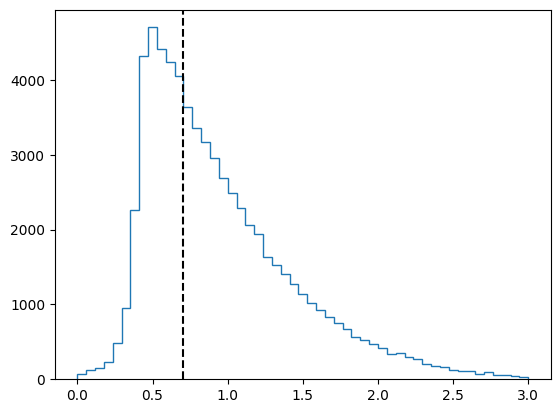

In [ ]:
plt.hist(snr.log10().numpy(), bins=51, range=(0, 3), histtype='step')
plt.axvline(0.7, linestyle='--', color='k')

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

snrs = (3, 5, 7, 10, 15, 20, 30, 40, 50, 70, 90, 100, 250, 500)
eps = 0.01

with PdfPages("snr_example.pdf") as pdf:
    for _snr in snrs:
        snr_min = _snr - eps * _snr
        snr_max = _snr + eps * _snr

        mask = (snr > snr_min) & ( snr < snr_max)
        assert sum(mask) >= 5
        _images = images[mask]
        _inds = np.random.choice(np.arange(len(_images)), size=5, replace=False)
        images_to_plot = _images[_inds]


        fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(28, 7))
        fig.suptitle(f"SNR={_snr}", fontsize=28)
        axs = axes.ravel()
        for ii, ax in enumerate(axs):
            ax.imshow(images_to_plot[ii, 0])
            ax.set_axis_off()
        plt.tight_layout()
        pdf.savefig()
        plt.close()
